In [65]:
import torch
import torchvision.transforms as transforms
from transformers import AutoFeatureExtractor, AutoProcessor, AutoTokenizer, VisionEncoderDecoderModel, VisionEncoderDecoderConfig,AutoModel
from PIL import Image
class CustomVisionEncoderDecoderModel(VisionEncoderDecoderModel):
    def prepare_inputs_for_generation(self, pixel_values, attention_mask=None, **kwargs):
        # Ensure the pixel_values has the correct shape
        print(pixel_values.shape)

        return {
            "pixel_values":pixel_values
        }


 


def load_vision_encoder_decoder_model(model_path, encoder_name, decoder_name, max_length, num_decoder_layers=None):
    config = VisionEncoderDecoderConfig.from_pretrained(model_path)
    encoder = AutoModel.from_pretrained(encoder_name)
    decoder = AutoModel.from_pretrained(decoder_name)

    if num_decoder_layers is not None:
        # Handle the number of decoder layers based on the model type if needed
        pass

    model = CustomVisionEncoderDecoderModel(encoder=encoder, decoder=decoder, config=config)

    model.config.decoder_start_token_id = model.config.pad_token_id
    model.config.eos_token_id = model.config.pad_token_id
    model.config.max_length = max_length
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4

    return model

# Replace 'path/to/saved/model' with the actual path where your model is saved
model_path = "final/"
encoder_name = 'facebook/deit-tiny-patch16-224'
decoder_name = 'cl-tohoku/bert-base-japanese-char-v2'
max_length = 300  # Replace with the actual maximum length
num_decoder_layers = 2  # Replace with the actual number of decoder layers

loaded_model = load_vision_encoder_decoder_model(model_path, encoder_name, decoder_name, max_length, num_decoder_layers=num_decoder_layers)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Config of the decoder: <class 'transformers.models.bert.modeling_bert.BertModel'> is overwritten by shared decoder config: BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-char-v2",
  "add_cross_attention": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": true,
  "layer_norm_eps": 1e-12,
  "max_length": 300,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding

In [86]:
import re
from pathlib import Path
import torch
from PIL import Image
from transformers import AutoFeatureExtractor, AutoTokenizer, VisionEncoderDecoderModel


class OCR:
    def __init__(self,model_path, force_cpu=False):
        self.feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/deit-tiny-patch16-224")
        self.tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-char-v2")
        self.model = VisionEncoderDecoderModel.from_pretrained(model_path)

        if not force_cpu and torch.cuda.is_available():
            print('Using CUDA')
            self.model.cuda()
        elif not force_cpu and torch.backends.mps.is_available():
            print('Using MPS')
            self.model.to('mps')
        else:
            print('Using CPU')

        print('OCR ready')

    def __call__(self, img_or_path):
        if isinstance(img_or_path, str) or isinstance(img_or_path, Path):
            img = Image.open(img_or_path)
        elif isinstance(img_or_path, Image.Image):
            img = img_or_path
        else:
            raise ValueError(f'img_or_path must be a path or PIL.Image, instead got: {img_or_path}')

        x = img
        x = self._preprocess(img)
        x = self.model.generate(x[None].to(self.model.device), max_length=300)[0].cpu()
        x = self.tokenizer.decode(x, skip_special_tokens=True)
        return x

    def _preprocess(self, img):
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        # Define the transformation
        return pixel_values.squeeze()

In [87]:
ocr = OCR(model_path='final/')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at final/ and are newly initialized: ['decoder.bert.encoder.layer.2.attention.self.value.bias', 'decoder.bert.encoder.layer.3.crossattention.self.value.weight', 'decoder.bert.encoder.layer.11.output.LayerNorm.weight', 'decoder.bert.encoder.layer.3.attention.output.LayerNorm.weight', 'decoder.bert.encoder.layer.10.attention.output.LayerNorm.weight', 'decoder.bert.encoder.layer.8.output.dense.bias', 'decoder.bert.encoder.layer.6.intermediate.dense.bias', 'decoder.bert.encoder.layer.7.attention.self.key.bias', 'decoder.bert.encoder.layer.4.attention.self.value.bias', 'decoder.bert.encoder.layer.9.crossattention.output.LayerNorm.bias', 'decoder.bert.encoder.layer.8.attention.self.key.weight', 'decoder.bert.encoder.layer.9.output.dense.weight', 'decoder.bert.encoder.layer.6.attention.output.LayerNorm.bias', 'decoder.bert.encoder.layer.9.attention.self.key.bias', 'decoder.bert.encoder.layer.8.attention.o

Using CUDA
OCR ready


In [92]:
ocr('train_imgs/1.jpg')

'た た'

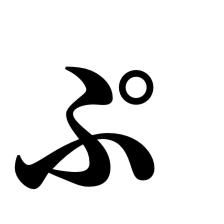

In [91]:
img = Image.open('train_imgs/100.jpg')
img = img.convert('L').convert('RGB')
img